In [1]:
import matplotlib.pyplot as plt
import sys
import pickle
sys.path.append("../tools/")
import warnings
warnings.filterwarnings('ignore')

from time import time

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data,test_classifier

from sklearn import tree
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import recall_score,precision_score,accuracy_score


In [2]:
### Selecting features to be used.
### features_list is a list of strings, each of which is a feature name.
features_list = ['poi',
                 'salary',
                 'deferral_payments',
                 'total_payments', 
                 'loan_advances', 
                 'bonus',
                 'restricted_stock_deferred',
                 'deferred_income', 
                 'total_stock_value', 
                 'expenses',
                 'exercised_stock_options',
                 'other',
                 'long_term_incentive', 
                 'restricted_stock',
                 'director_fees',
                 'to_messages',
                 'from_poi_to_this_person', 
                 'from_messages',
                 'from_this_person_to_poi',
                 'shared_receipt_with_poi',
                ] 

### Loading the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

Scatter plot before removing outliers


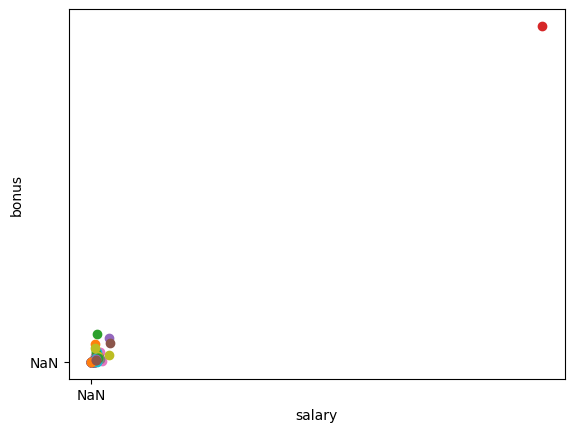

Scatter plot after removing outliers


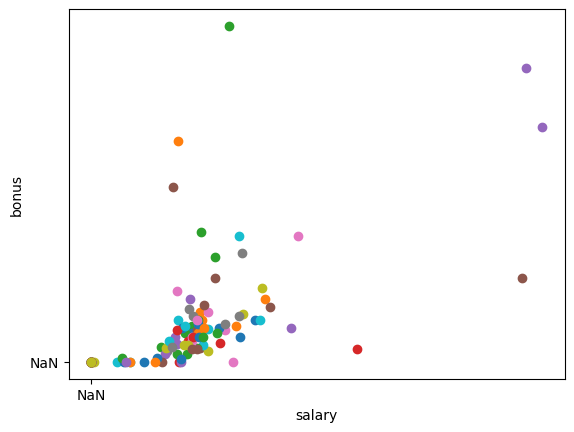

In [3]:
print ("Scatter plot before removing outliers")   
for point in data_dict:
    salary = data_dict[point]["salary"]
    bonus = data_dict[point]["bonus"]
    plt.scatter( salary, bonus)

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

### Removing outliers
out=['TOTAL','LOCKHART EUGENE E','THE TRAVEL AGENCY IN THE PARK']

for i in out:
    data_dict.pop(i)
    
print ("Scatter plot after removing outliers")   
for point in data_dict:
    salary = data_dict[point]["salary"]
    bonus = data_dict[point]["bonus"]
    plt.scatter( salary, bonus)


plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()


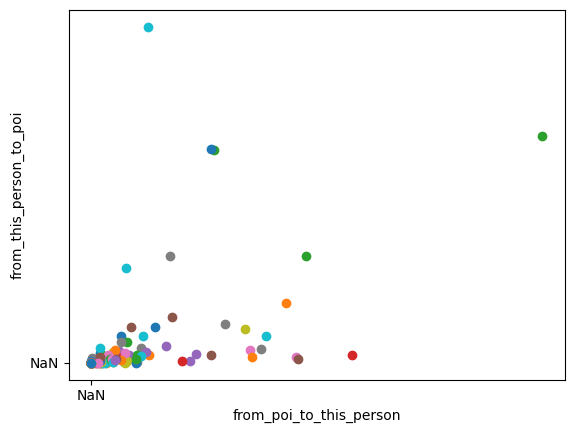

In [4]:
for point in data_dict:
    from_poi_to_this_person = data_dict[point]["from_poi_to_this_person"]
    from_this_person_to_poi = data_dict[point]["from_this_person_to_poi"]
    plt.scatter( from_poi_to_this_person, from_this_person_to_poi)

plt.xlabel("from_poi_to_this_person")
plt.ylabel("from_this_person_to_poi")
plt.show()


In [5]:

from sklearn.feature_selection import SelectKBest,f_classif
f_scores =[]



def pf(data_dict):
    for k, v in data_dict.items():
#Assigning value to the feature 'proportion_from_poi'

        if v['from_poi_to_this_person'] != 'NaN' and  v['from_messages'] != 'NaN':
            v['proportion_from_poi'] = float(v['from_poi_to_this_person']) / v['from_messages'] 
        else:    
            v['proportion_from_poi'] = 0.0
    return (data_dict)       
            
def pt(data_dict):
    for k, v in data_dict.items():
        #Assigning value to the feature 'proportion_to_poi'        
        if v['from_this_person_to_poi'] != 'NaN' and  v['to_messages'] != 'NaN':
            v['proportion_to_poi'] = float(v['from_this_person_to_poi'] )/ v['to_messages']   
        else:
            v['proportion_to_poi'] = 0.0
    return (data_dict)


In [6]:
def net_worth (data_dict) :
    features = ['total_payments','total_stock_value']
    
    for key in data_dict :
        name = data_dict[key]
        
        is_null = False 
        
        for feature in features:
            if name[feature] == 'NaN':
                is_null = True
        
        if not is_null:
            name['net_worth'] = name[features[0]] + name[features[1]]
        
        else:
            name['net_worth'] = 'NaN'
            
    return data_dict                
            
def select_features(features,labels,features_list,k=10) :
    clf = SelectKBest(f_classif,k=k)
    new_features = clf.fit_transform(features,labels)
    features_l=[features_list[i+1] for i in clf.get_support(indices=True)]
    f_scores = zip(features_list[1:],clf.scores_[:])
    f_scores = sorted(f_scores,key=lambda x: x[1],reverse=True)
    return new_features, ['poi'] + features_l, f_scores

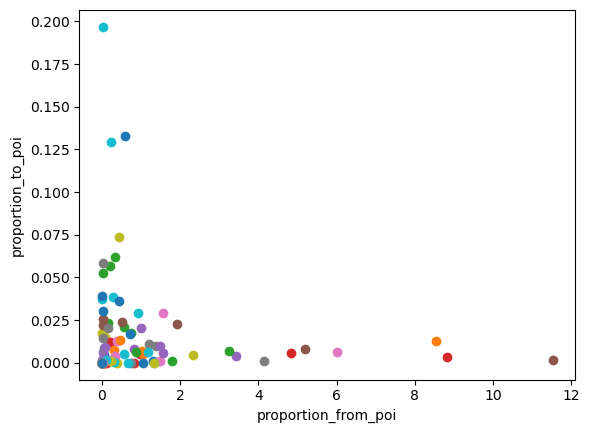

In [7]:
### Creating new feature(s)
### Storing to my_dataset for easy export below.
data_dict = net_worth(data_dict)

data_dict=pf(data_dict)
data_dict=pt(data_dict)
features_list+=['net_worth','proportion_from_poi','proportion_to_poi']

my_dataset = data_dict
### Extracting features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

for point in data_dict:
    proportion_from_poi = data_dict[point]["proportion_from_poi"]
    proportion_to_poi = data_dict[point]["proportion_to_poi"]
    plt.scatter( proportion_from_poi, proportion_to_poi)

plt.xlabel("proportion_from_poi")
plt.ylabel("proportion_to_poi")
plt.show()


In [8]:
features,features_list,f_scores=select_features(features,labels,features_list,k=6)
# calling the function with uses selectkbest
print ("features_list---" ,features_list)
print("feature scores")
for i in f_scores:
    print (i)
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)


features_list--- ['poi', 'salary', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options', 'net_worth']
feature scores
('exercised_stock_options', 24.815079733218194)
('total_stock_value', 24.18289867856688)
('bonus', 20.792252047181535)
('salary', 18.289684043404513)
('net_worth', 17.80879117424012)
('deferred_income', 11.458476579280369)
('long_term_incentive', 9.922186013189823)
('restricted_stock', 9.2128106219771)
('total_payments', 8.772777730091676)
('shared_receipt_with_poi', 8.589420731682381)
('loan_advances', 7.184055658288725)
('expenses', 6.094173310638945)
('from_poi_to_this_person', 5.243449713374958)
('proportion_from_poi', 5.123946152756893)
('other', 4.187477506995375)
('proportion_to_poi', 4.094653309576953)
('from_this_person_to_poi', 2.382612108227674)
('director_fees', 2.1263278020077054)
('to_messages', 1.6463411294420076)
('deferral_payments', 0.2246112747360099)
('from_messages', 0.16970094762175533)
('restricted_stock_deferred', 0.065499652

In [9]:
### Trying a variety of classifiers
# Provided to give you a starting point. Try a variety of classifiers.

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
test_classifier(clf,my_dataset,features_list)


GaussianNB()
	Accuracy: 0.85250	Precision: 0.47866	Recall: 0.36450	F1: 0.41385	F2: 0.38276
	Total predictions: 14000	True positives:  729	False positives:  794	False negatives: 1271	True negatives: 11206



In [10]:
from sklearn.tree import DecisionTreeClassifier
clf1=tree.DecisionTreeClassifier()
test_classifier(clf1,my_dataset,features_list)

DecisionTreeClassifier()
	Accuracy: 0.78693	Precision: 0.25139	Recall: 0.24850	F1: 0.24994	F2: 0.24907
	Total predictions: 14000	True positives:  497	False positives: 1480	False negatives: 1503	True negatives: 10520



In [11]:
from sklearn.ensemble import AdaBoostClassifier
clf2 = AdaBoostClassifier()
test_classifier(clf2,my_dataset,features_list)

AdaBoostClassifier()
	Accuracy: 0.83093	Precision: 0.37213	Recall: 0.26700	F1: 0.31092	F2: 0.28299
	Total predictions: 14000	True positives:  534	False positives:  901	False negatives: 1466	True negatives: 11099



In [12]:


from sklearn.neighbors import KNeighborsClassifier
clf3=KNeighborsClassifier(n_neighbors = 4)
test_classifier(clf3,my_dataset,features_list)

KNeighborsClassifier(n_neighbors=4)
	Accuracy: 0.85143	Precision: 0.30198	Recall: 0.03050	F1: 0.05540	F2: 0.03719
	Total predictions: 14000	True positives:   61	False positives:  141	False negatives: 1939	True negatives: 11859



In [13]:
from sklearn.neighbors import NearestCentroid
clf4 = NearestCentroid()
test_classifier(clf4,my_dataset,features_list)

NearestCentroid()
	Accuracy: 0.82543	Precision: 0.35714	Recall: 0.27750	F1: 0.31232	F2: 0.29045
	Total predictions: 14000	True positives:  555	False positives:  999	False negatives: 1445	True negatives: 11001



In [14]:
from sklearn.ensemble import RandomForestClassifier
clf5 = RandomForestClassifier()
test_classifier(clf5,my_dataset,features_list)

RandomForestClassifier()
	Accuracy: 0.85950	Precision: 0.52010	Recall: 0.21350	F1: 0.30273	F2: 0.24204
	Total predictions: 14000	True positives:  427	False positives:  394	False negatives: 1573	True negatives: 11606



In [15]:
### Tuning the classifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)
 
t = time()
pipe1 = Pipeline([('pca',PCA()),('classifier',GaussianNB())])
param = {'pca__n_components':[4,5,6]}
gsv = GridSearchCV(pipe1, param_grid=param,n_jobs=2,scoring = 'f1',cv=2)
gsv.fit(features_train,labels_train)
clf = gsv.best_estimator_
print("GausianNB with PCA fitting time: %rs" % round(time()-t, 3))
pred = clf.predict(features_test)

t = time()
test_classifier(clf,my_dataset,features_list,folds = 1000)
print("GausianNB  evaluation time: %rs" % round(time()-t, 3))

GausianNB with PCA fitting time: 1.616s
Pipeline(steps=[('pca', PCA(n_components=5)), ('classifier', GaussianNB())])
	Accuracy: 0.85214	Precision: 0.47796	Recall: 0.37950	F1: 0.42308	F2: 0.39581
	Total predictions: 14000	True positives:  759	False positives:  829	False negatives: 1241	True negatives: 11171

GausianNB  evaluation time: 1.47s


In [16]:
adbc = AdaBoostClassifier(random_state=40)
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
dt = []
for i in range(6):
   dt.append(DecisionTreeClassifier(max_depth=(i+1)))
adbpara = {'base_estimator': dt,'n_estimators': [60,45, 101,10]}
t = time()
adbt = GridSearchCV(adbc, adbpara, scoring='f1',)
adbt = adbt.fit(features_train,labels_train)
print("AdaBoost fitting time: %rs" % round(time()-t, 3))
adbc = adbt.best_estimator_
t = time()
test_classifier(adbc, data_dict, features_list, folds = 100)
print("AdaBoost evaluation time: %rs" % round(time()-t, 3))

AdaBoost fitting time: 4.179s
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   n_estimators=45, random_state=40)
	Accuracy: 0.85643	Precision: 0.49650	Recall: 0.35500	F1: 0.41399	F2: 0.37646
	Total predictions: 1400	True positives:   71	False positives:   72	False negatives:  129	True negatives: 1128

AdaBoost evaluation time: 4.563s


In [17]:
## Dumping the classifier, dataset, and features_list

dump_classifier_and_data(clf, my_dataset, features_list)